In [64]:
using PyPlot
import CMB.Legendre: LegendreSphereCoeff

function integrate_trapz(f, xs)
    N = length(xs)
    I = copy(f(xs[1]))
    I .+= f(xs[end])
    I .*= one(xs[1]) / 2
    for x in xs[2:end-1]
        I .+= f(x)
    end
    I .+= step(xs)
    return I
end

function integrate_simpson(f, xs)
    N = length(xs)
    I = copy(f(xs[1]))
    I .+= f(xs[end])
    for x in xs[2:2:end-1]
        I .+= oftype(x, 2)/3 .* f(x)
    end
    for x in xs[3:2:end-1]
        I .+= oftype(x, 4)/3 .* f(x)
    end
    I .*= step(xs)
    return I
end

# _sinc(x) == sinc(x/π) without the extra division
_sinc(x) = iszero(x) ? one(sin(zero(x))) : sin(x) / x

function pixel_window_function(θmin, θmax, φmin, φmax;
        lmax::Int=720, nstep::Int=100, eltype::Type=Float64)

    nstep += mod(nstep, 2) # Forces nstep to be even
    ell = 0:lmax
    zmin, zmax = cos.(convert.(eltype, (θmax, θmin)))
    zs = range(zmin, stop=zmax, length=nstep)
    Δz, Δφ = eltype.((zmax - zmin, φmax - φmin))

    Λfn(z) = let Λtmp = zeros(eltype, lmax+1, lmax+1),
                 Λtab! = LegendreSphereCoeff{eltype}(lmax)
        Λtab!(Λtmp, z)
    end
    Λ = integrate_simpson(Λfn, zs)
    #Λ = integrate_trapz(Λfn, zs)
    Λ[:,2:end] .*= sqrt(2) # double to account for m ≤ -1

    Φ(m) = (Δφ * _sinc(m * Δφ/2))^2

    wlm2 = squeeze(sum(Λ.^2 .* Φ.(ell'), dims=2), dims=2)
    norm = 4π / (Δφ * Δz)^2
    Wl = sqrt.(norm ./ (2 .* ell .+ 1) .* wlm2)
    return (ell, Wl, Λ)
end


pixel_window_function (generic function with 1 method)

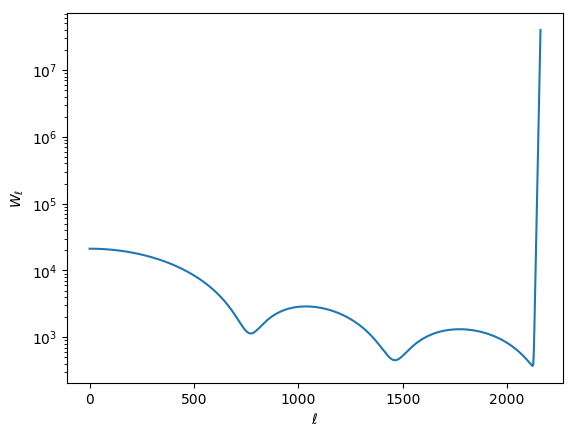

PyObject <matplotlib.text.Text object at 0x2b49abcd50f0>

In [65]:
Δδ, Δλ = (0.250,   0.466)
δ₀, λ₀ = (-57.625, 0.000)

θlim = deg2rad.(90.0 .- (δ₀ .+ (Δδ .* (1, -1))))
φlim = deg2rad.(λ₀ .+ (Δλ .* (-1, 1)))
(l, Wl, Λ) = pixel_window_function(θlim..., φlim..., lmax=3*720)
semilogy(l, Wl)
xlabel(raw"$\ell$")
ylabel(raw"$W_\ell$")

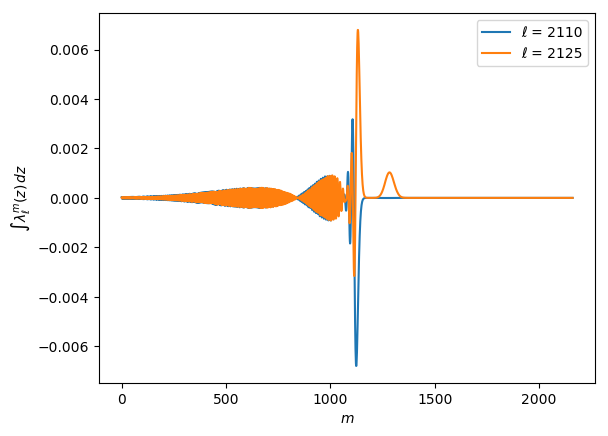

In [59]:
plot(l, Λ[2110, :], label="ℓ = 2110")
plot(l, Λ[2125, :], label="ℓ = 2125")
legend()
xlabel(raw"$m$")
ylabel(raw"$\int\lambda_\ell^m(z)\,dz$")
nothing

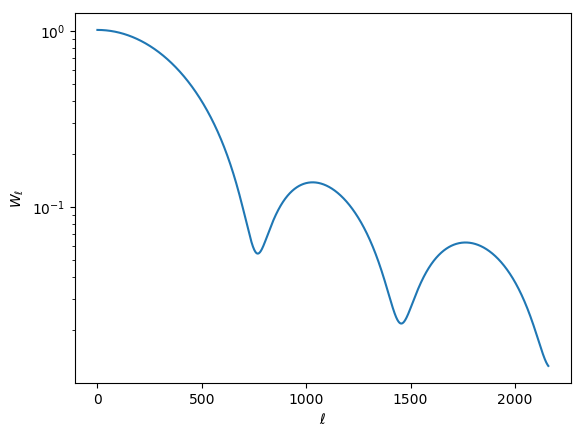

PyObject <matplotlib.text.Text object at 0x2b49ae22f4e0>

In [62]:
#(lb, Wlb, Λb) = pixel_window_function(θlim..., φlim..., lmax=3*720, eltype=BigFloat)
semilogy(lb, Float64.(Wlb))
xlabel(raw"$\ell$")
ylabel(raw"$W_\ell$")

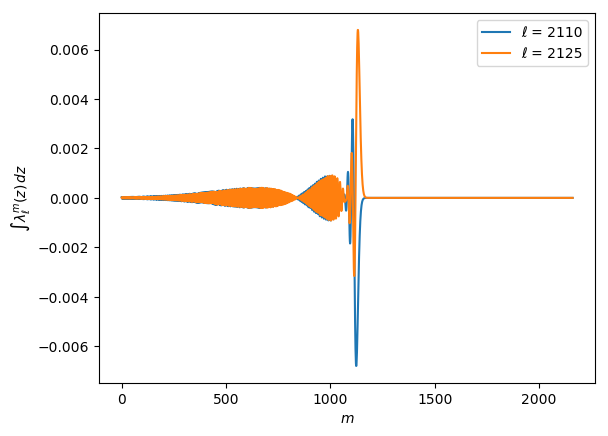

In [63]:
plot(l, Float64.(Λb[2110, :]), label="ℓ = 2110")
plot(l, Float64.(Λb[2125, :]), label="ℓ = 2125")
legend()
xlabel(raw"$m$")
ylabel(raw"$\int\lambda_\ell^m(z)\,dz$")
nothing